In [1]:
import lowfieldsim
import scipy.io
from fastMRI.data import transforms as Ttorch
import lowfieldsim as simulator_MRI
import Unet_MRI_7T3 as Unet
import matplotlib.pyplot as plt
import numpy as np
import torch


%load_ext autoreload
%autoreload 2

Using device: cpu


In [2]:
mat_contents = scipy.io.loadmat('fat-water@3T-3echo.mat')
B0_low = 0.3
sorted(mat_contents.keys())
k_high_T = Ttorch.to_tensor(mat_contents['k_high'])

In [3]:
print(k_high_T.shape)

torch.Size([168, 168, 1, 3, 8, 2])


### <font size=15> Testing simulator with known input 


In [4]:
Test_lowfieldsim = simulator_MRI.lowfieldsim()
low_res_real, high_res_real,img_low_combined ,img_high_combined = Test_lowfieldsim.lowfieldsim(k_high_T[:128,:128])
# *_res_real is image with size [image_w, image_h, #coils]

In [5]:
# img_low_combined = img_low_combined.numpy()
# img_low_combined = (img_low_combined - np.amin(img_low_combined))/ (np.amax(img_low_combined)-np.amin(img_low_combined))
# print(low_res_real[0,0,0])
# print(np.amin(img_low_combined))

Text(0.5, 1.0, 'Simulated @ 0.5 T')

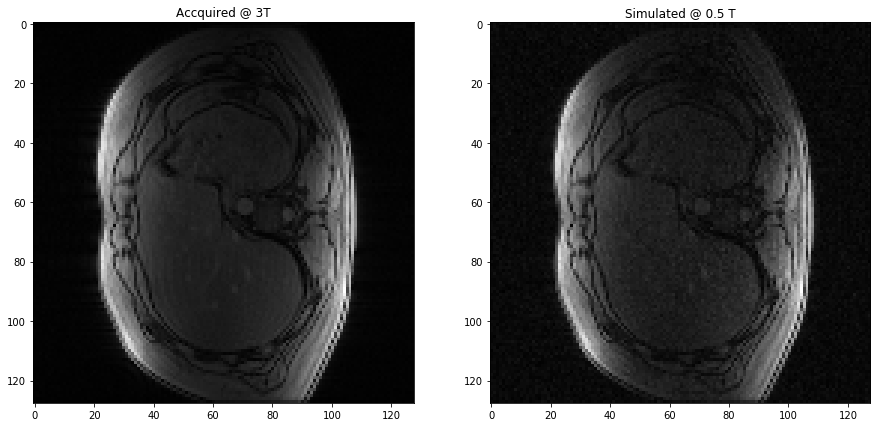

In [6]:
plt.figure(figsize=(15, 15))

# Accquired
plt.subplot(121),
plt.imshow(np.sqrt((img_high_combined)), cmap='gray')
plt.title('Accquired @ 3T')

# low field
plt.subplot(122),
plt.imshow(np.sqrt((img_low_combined)), cmap='gray');
plt.title("Simulated @ 0.5 T" )

### <font size=15> Testing MRI_Unet get_data function

In [8]:
Testing_get_data = Unet.get_data
input_mr, target, output_gt = Testing_get_data(k_high_T)

In [9]:
#Target should be lowfield MRI
print(target.shape)
target_per = target.permute(1,2,0)
print(target.shape)

#Output ground thrut is the high field image
print(output_gt.shape)
output_gt_per = output_gt.permute(1,2,0)
print(output_gt.shape)

torch.Size([8, 128, 128])
torch.Size([8, 128, 128])
torch.Size([8, 128, 128])
torch.Size([8, 128, 128])


Text(0.5, 1.0, 'Simulated @ 0.5 T')

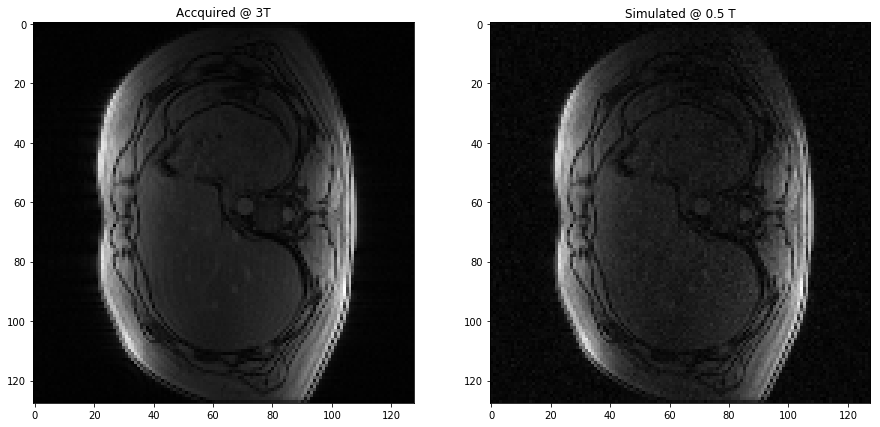

In [10]:
plt.figure(figsize=(15, 15))

# Accquired
plt.subplot(121),
plt.imshow(np.sqrt(torch.sum(output_gt_per,2)), cmap='gray')
plt.title('Accquired @ 3T')

# low field
plt.subplot(122),
plt.imshow(np.sqrt(torch.sum(target_per,2)), cmap='gray');
plt.title("Simulated @ 0.5 T" )

### <font size=15> Testing MRI_Unet end to end

In [22]:
%run Unet_MRI_7T3.py --num-chans 8 --batch-size 1 --checkpoint checkpoint/best_model.pt  --challenge multicoil --data-path \ --num_coil 8 --device cpu --lr 0.001 --num-epochs 2000 --report-interval 10

UnetModel(
  (down_sample_layers): ModuleList(
    (0): ConvBlock(in_chans=8, out_chans=8, drop_prob=0.0)
    (1): ConvBlock(in_chans=8, out_chans=16, drop_prob=0.0)
    (2): ConvBlock(in_chans=16, out_chans=32, drop_prob=0.0)
    (3): ConvBlock(in_chans=32, out_chans=64, drop_prob=0.0)
  )
  (conv): ConvBlock(in_chans=64, out_chans=64, drop_prob=0.0)
  (up_sample_layers): ModuleList(
    (0): ConvBlock(in_chans=128, out_chans=32, drop_prob=0.0)
    (1): ConvBlock(in_chans=64, out_chans=16, drop_prob=0.0)
    (2): ConvBlock(in_chans=32, out_chans=8, drop_prob=0.0)
    (3): ConvBlock(in_chans=16, out_chans=8, drop_prob=0.0)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 4, kernel_size=(1, 1), stride=(1, 1))
    (1): Conv2d(4, 8, kernel_size=(1, 1), stride=(1, 1))
    (2): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1))
  )
)
RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.001
    momentum: 0
    weight_decay: 0.0
)
Epoch = [   0/2000] TrainLoss = 

In [23]:
epoch_5000 = torch.load('test.pt')
print(epoch_5000.shape)

torch.Size([1, 8, 128, 128])


In [24]:
epoch_5000 = epoch_5000.squeeze(0)
print(epoch_5000.shape)
epoch_5000 = epoch_5000.permute(1,2,0)
print(epoch_5000.shape)

torch.Size([8, 128, 128])
torch.Size([128, 128, 8])


Text(0.5, 1.0, 'Accquired @ 3T')

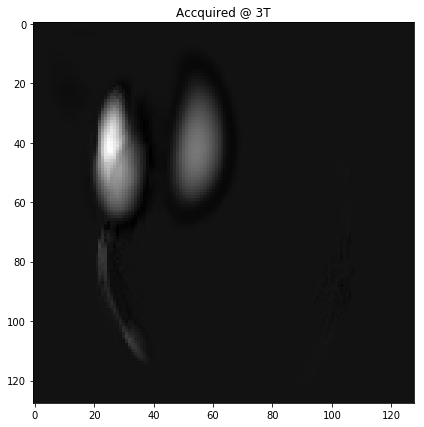

In [25]:
epoch_5000 = epoch_5000.detach().numpy()

plt.figure(figsize=(15, 15))

# Accquired
plt.subplot(121),
plt.imshow(np.sqrt(np.sum(abs(epoch_5000),2)), cmap='gray')
plt.title('Accquired @ 3T')
